In [1]:
from utils import *
from matplotlib.font_manager import FontProperties
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24

import pickle as pkl
CACHE_FILE = "froude_cache"
F_SIZE = 10
if os.path.exists(CACHE_FILE):
    cache = pkl.load(open(CACHE_FILE, "rb"))
else:
    cache = {}
print(f"Cache has {len(cache)} matrices stored")

Cache has 1000 matrices stored


In [2]:
#----Creating custom ColorMap using colors from colorbrewer2.com-----#

# Blue to red color scheme
color_rgbs = [
[178,24,43],
 [239,138,98],
[253,219,199],
# [255, 243, 228],
[33,102,172]
]

color_rgbs = [list((c / 256 for c in l)) for l in color_rgbs][::-1]
custom_map = ListedColormap(color_rgbs, name="custom")


In [3]:
def calc_froude_matrix(n_samples, params, ranges, binary=True, log=False, use_cache=True): 
    """
    Accepts model parameters and variables ranges, calculates the 
    design matrix M (n_samples, 2 * n_samples) where M[i, j] is the 
    values of Yih's J calculated with the i'th value of n and 
    j'th value of m. 
    """
    N_MIN, N_MAX, N_MIN2, N_MAX2, F_MIN, F_MAX = \
        (ranges["N_MIN"], ranges["N_MAX"], ranges["N_MIN2"], ranges["N_MAX2"], ranges["F_MIN"], ranges["F_MAX"])
    
    rho1, rho2, mu1, mu2, d1, g, U0, flow_height = params["rho1"], params["rho2"], \
        params["mu1"], params["mu2"], params["d1"], params["g"], params["U0"], params["flow_height"]
    
    key = (n_samples, N_MIN, N_MAX, N_MIN2, N_MAX2, F_MIN, F_MAX, rho1, rho2, mu1, d1, log, g, U0, flow_height)
    
    if key in cache and use_cache:
        print("Using previously cached matrix")
        result = cache[key]
        
        if binary:
            result[result > 0] = 1
            result[result <= 0] = 0
            
        return result
    
    d2s = np.linspace(N_MIN, N_MAX, n_samples)
    Fs = np.logspace(F_MAX, F_MIN, num=n_samples) 

    right_d2s = np.linspace(N_MIN2, N_MAX2, n_samples)
    d2s = np.concatenate([d2s, right_d2s])

    results = np.empty((n_samples, 2 * n_samples))
    
    for i, d2 in enumerate(d2s):
        for j, F in enumerate(Fs):
            params["d2"] = d2
            params["F"] = F
            J, F = yihJ(**params)
            results[j, i] = J
    
    cache[key] = results
    pkl.dump(cache, open(CACHE_FILE, "wb"))
    
    if binary:
        results[results > 0] = 1
        results[results <= 0] = 0
    
    return results

In [4]:
d_matrix = np.zeros_like(calc_froude_matrix(ranges["N_SAMPLES"], params, ranges, binary=True, log=False, use_cache=False))
for mu1 in [3, 5, 10]:
    params["mu1"] = mu1
    d_matrix += calc_froude_matrix(ranges["N_SAMPLES"], params, ranges, binary=True, log=False, use_cache=False)
    

NameError: name 'ranges' is not defined

In [5]:
print(d_matrix.shape)

CUTOFF = 778
MARKER_SIZE = 15
LABEL_SIZE = 28
FONT_SIZE = 20

fig, ax = plt.subplots(figsize=(10,10))

plt.tick_params(axis='x', bottom=False)
plt.tick_params(axis='y', left=False)

im1 = ax.imshow(d_matrix[:, CUTOFF:], cmap=custom_map, interpolation="nearest", alpha=.75)

xx, yy = np.meshgrid(range(2 * ranges["N_SAMPLES"] - CUTOFF), np.logspace(-2, 1, num=ranges["N_SAMPLES"]))

# Try to edit it here, passing incorrect levels into contour
ax.contour(xx[0], yy[:, 0], d_matrix[:, CUTOFF:], colors="black", linewidths=10)

# tic locations
locs_y = np.linspace(0, ranges["N_SAMPLES"], ranges["NUM_LABELS_Y"])
locs_x = np.linspace(0, 2 * ranges["N_SAMPLES"], ranges["NUM_LABELS_X"])

locs_x = [loc - CUTOFF if idx != 0 else loc for idx, loc in enumerate(locs_x)]

# Keep tics from running off the graph
locs_x[-1] -= 2
locs_y[-1] -= 13

# avoid collision at bottom left corner
locs_x[0] += 2
locs_y[0] += 2

# tic labels 
y_labels = ranges["Y_LABELS"]
x_labels = ranges["X_LABELS"]
x_labels[0] = round(np.linspace(ranges["N_MIN"], ranges["N_MAX"], ranges["N_SAMPLES"])[CUTOFF], 2)

ax.set_yticks(locs_y)
ax.set_yticklabels(y_labels, fontsize=20)
#ax.set_yscale('log')

ax.set_xticks(locs_x)
ax.set_xticklabels(x_labels.copy(), fontsize=22)

# axes labels
ax.set_ylabel("Fr", fontsize=LABEL_SIZE)
ax.set_xlabel("Height ratio n = $d_L$ / $d_U$", fontsize=LABEL_SIZE)

plt.plot(500, 220, 'o', markersize=MARKER_SIZE, color="black")
plt.plot(585, 355, 's', markersize=MARKER_SIZE, color="black")
plt.plot(675, 445, '^', markersize=MARKER_SIZE, color="black")


m1_line = mlines.Line2D([], [], color='black', label='m = .1', marker="o", markersize=MARKER_SIZE)
m2_line = mlines.Line2D([], [], color='black', label='m = .2', marker="s", markersize=MARKER_SIZE)
m3_line = mlines.Line2D([], [], color='black', label='m = .33', marker="^", markersize=MARKER_SIZE)

plt.legend(handles=[m1_line, m2_line, m3_line], \
           loc="upper left", fontsize=22)

plt.arrow(585, 355, -60, -95, head_width=15, head_length=30, color="black")

plt.text(450, 970, "Smaller froude numbers are unstable", fontsize=FONT_SIZE + 2)
plt.text(545, 275, "Increased viscosity contrast expands\n regions of instability", fontsize=FONT_SIZE)
fig.savefig(f"phase_diagrams/froude_diagram", bbox_inches='tight')

NameError: name 'd_matrix' is not defined

In [8]:
SIZE = int(1e3)
F_RANGE = (-2,0)
ranges = {
    "N_MIN" : .2,
    "N_MAX" : .9999999,

    "N_MIN2" : 1,
    "N_MAX2" : 5,

#     "F_MIN" : F_RANGE[0], # powers of 10
#     "F_MAX" : 0,
    
    "NUM_LABELS_Y" : 2,
    "NUM_LABELS_X" : 3,
    
    "X_LABELS" : [.2, 1, 5], 

    "N_SAMPLES" : SIZE
}

#ranges["Y_LABELS"] = [ranges["F_MAX"], ranges["F_MIN"]]

params = {
    "g" : 9.8,
    "U0": 5,
    "dP" : 0,

    "verbose" : False,

    "mu1" : 2,
    "mu2" : 1, 
    "rho1" : .99,
    "rho2" : 1,
    "d1" : 1,
    "d2" : 5,
    
    "flow_height" : 3
}

d2s = np.concatenate((np.linspace(.2, 1, SIZE), np.linspace(1, 5, SIZE)))
froudes = np.logspace(F_RANGE[0], F_RANGE[1], num=SIZE)


In [9]:
d2d2, ff = np.meshgrid(d2s, froudes)
z = np.zeros((len(d2s), len(froudes))).T
z2 = np.zeros((len(d2s), len(froudes))).T
if os.path.exists("froude_cache"):
    z = pkl.load(open("froude_cache", "rb"))

In [10]:
if z.sum() == 0:
    for mu1 in [3, 5, 10]:
        params["mu1"] = mu1
        for y_idx, d2 in enumerate(d2s):
            params["d2"] = d2
            for x_idx, F in enumerate(froudes):
                params["F"] = F
                J, F = yihJ(**params)
                z[x_idx, y_idx] += int(J > 0)


In [11]:
params['dP'] = .01
if z2.sum() == 0:
    for mu1 in [3, 5, 10]:
        params["mu1"] = mu1
        for y_idx, d2 in enumerate(d2s):
            params["d2"] = d2
            for x_idx, F in enumerate(froudes):
                params["F"] = F
                J, F = yihJ(**params)
                z2[x_idx, y_idx] += int(J > 0)

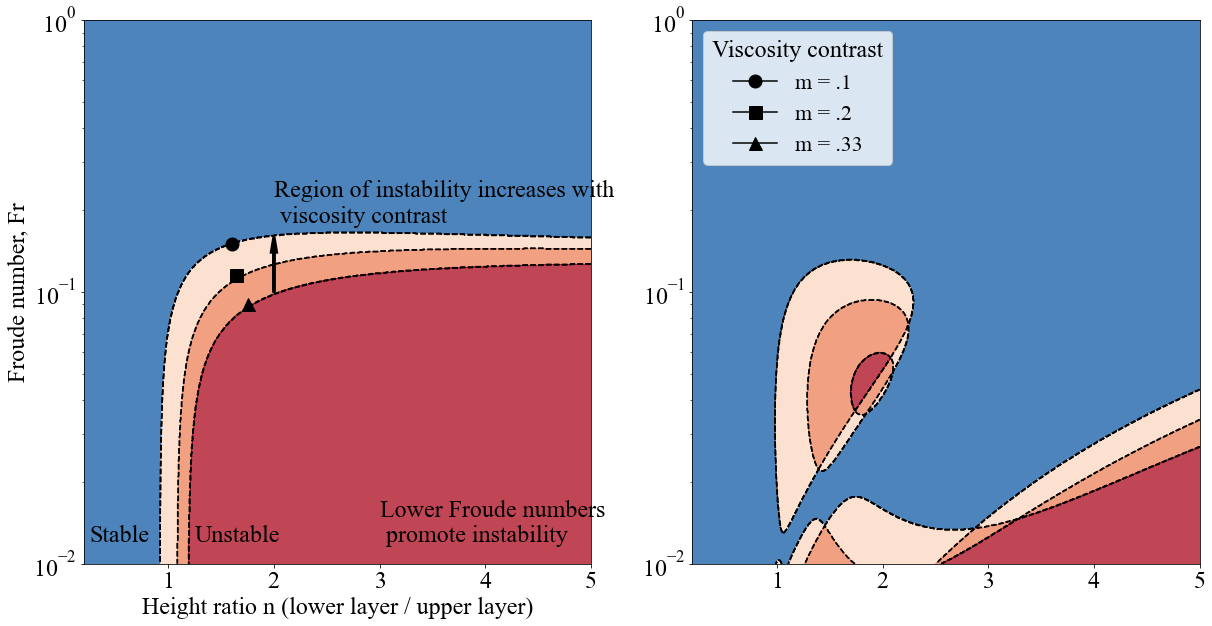

In [12]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax.contourf(d2d2, ff, z, cmap=custom_map, alpha=.8)
ax.contour(d2d2, ff, z, colors="black", linestyles="--")
ax.set_yscale('log')

ax2.contourf(d2d2, ff, z2, cmap=custom_map, alpha=.8)
ax2.contour(d2d2, ff, z2, colors="black", linestyles="--")
ax2.set_yscale('log')

MARKER_SIZE = 13

m1_line = mlines.Line2D([], [], color='black', label='m = .1', marker="o", markersize=MARKER_SIZE)
m2_line = mlines.Line2D([], [], color='black', label='m = .2', marker="s", markersize=MARKER_SIZE)
m3_line = mlines.Line2D([], [], color='black', label='m = .33', marker="^", markersize=MARKER_SIZE)

ax.plot(1.6, .15, 'o', markersize=MARKER_SIZE, color="black")
ax.plot(1.64, .115, 's', markersize=MARKER_SIZE, color="black")
ax.plot(1.75, 0.09, '^', markersize=MARKER_SIZE, color="black")

ax.arrow(2, .10, .0, .04, head_width=.05, head_length=.02, color="black", linewidth=3)
ax.text(2, .18, "Region of instability increases with\n viscosity contrast")

ax.text(.25, .012, "Stable")
ax.text(1.25, .012, "Unstable")
ax.text(3, .012, "Lower Froude numbers\n promote instability")

ax.set_ylabel("Froude number, Fr")
ax.set_xlabel("Height ratio n (lower layer / upper layer)")

plt.legend(handles=[m1_line, m2_line, m3_line], \
           loc="upper left", fontsize=22, title="Viscosity contrast")

fig.savefig(f"phase_diagrams/froude_final_k{str(params['dP']).replace('.', ',')}", bbox_inches="tight")

In [7]:
pkl.dump(z, open("froude_cache", "wb"))